# Extended figure 

## Plot the PIK3CA sequenced region and the positive selection there

In [1]:
import sys, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker



In [2]:
import sys
sys.path.append('../../')
from consensus_variables import *

In [3]:
pd.set_option('display.max_columns', None)

# Define gene order and plot and data directories

In [4]:
plots_dir = "./plots"
data_dir = "./data"

In [5]:
somatic_maf = pd.read_table(somatic_maf_file)

/tmp/ipykernel_3335094/2623433630.py:1: DtypeWarning: Columns (49,92,112) have mixed types. Specify dtype option on import or set low_memory=False.
  somatic_maf = pd.read_table(somatic_maf_file)


In [6]:
somatic_maf_clean = somatic_maf[(somatic_maf["canonical_SYMBOL"].isin(panel_all_genes)) 
                                & (somatic_maf["TYPE"] == 'SNV')
                                & (somatic_maf["canonical_SYMBOL"] == 'PIK3CA')
                                & (~somatic_maf["FILTER.not_in_exons"])
                                & (somatic_maf['canonical_Protein_position'] != '-')
                                ].reset_index(drop = True)
somatic_maf_clean['canonical_Protein_position'] = somatic_maf_clean['canonical_Protein_position'].astype(int)

counts_per_position = somatic_maf_clean.groupby(by = ["SAMPLE_ID", "canonical_SYMBOL", 'canonical_Consequence_broader', 'canonical_Protein_position'])['ALT_DEPTH'].size().to_frame('Count').reset_index()
counts_per_position.columns = ["SAMPLE_ID", 'Gene', 'Consequence', 'Pos', 'Count']
counts_per_position.head()

,SAMPLE_ID,Gene,Consequence,Pos,Count
0,P19_0001_BDO_01,PIK3CA,missense,1047,1
1,P19_0001_BTR_01,PIK3CA,missense,1047,1
2,P19_0002_BDO_01,PIK3CA,missense,1011,1
3,P19_0002_BDO_01,PIK3CA,missense,1047,1
4,P19_0002_BTR_01,PIK3CA,missense,1024,1


In [7]:
# mutations_in_tert_promoter.groupby(by = 'MUT_ID').size().sort_values(ascending = False).head(6)

In [8]:
# mutations_in_tert_promoter[mutations_in_tert_promoter["MUT_ID"] == "chr5:1295113_G>A"].iloc[0,4]

In [9]:
def plot_count_track(count_df, 
                        gene_len,
                        axes, 
                        colors_dict,
                        ax=0, 
                        negative=False, 
                        label_pos_track=None,
                        label_neg_track=None,
                        ymargin=None,
                        alpha=1,
                        indel=False,
                        n_batches = 10
                    ):

    # Shuffle the data and split into batches
    shuffled_df = count_df.sample(frac=1, random_state=42).reset_index(drop=True)
    batches = np.array_split(shuffled_df, n_batches)

    legend_list = []
    pos_df = pd.DataFrame({"Pos" : range(1, gene_len+1)})
    
    for batch_idx, batch in enumerate(batches):
        for cnsq in [#'indel',
                     'nonsense', 'missense', 'synonymous',
                     # 'splicing'
                    ]:
            
            if indel == False and cnsq == "indel":
                continue
        
            count_cnsq_df = batch[batch["Consequence"] == cnsq].reset_index(drop=True)
            count_cnsq_df = pos_df.merge(count_cnsq_df, on="Pos", how="left")
    
            axes[ax].vlines(count_cnsq_df["Pos"], ymin=0, ymax=count_cnsq_df["Count"], lw=1, zorder=1, alpha=0.5, color=colors_dict["hv_lines_needle"])
            axes[ax].scatter(count_cnsq_df["Pos"], count_cnsq_df["Count"], s=20, color='white', zorder=3, lw=0.1, ec="none") # To cover the overlapping needle top part

            if cnsq not in legend_list:
                axes[ax].scatter(count_cnsq_df["Pos"].values, count_cnsq_df["Count"].values, zorder=4, 
                                 alpha=alpha, lw=0.1, ec="none", s=20, label= "Truncating" if cnsq == 'nonsense' else cnsq.capitalize(), color=colors_dict[cnsq]) 
                legend_list.append(cnsq)
            else:
                axes[ax].scatter(count_cnsq_df["Pos"].values, count_cnsq_df["Count"].values, zorder=4, 
                                 alpha=alpha, lw=0.1, ec="none", s=20, color=colors_dict[cnsq]) 


/home/fcalvet/miniforge3/envs/notebooks_env/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


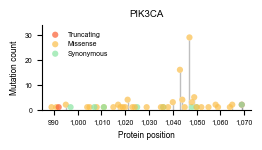

In [11]:
donor, samplesss = ('All samples', all_sample_names_dirty)
gene = "PIK3CA"

mut_count_df = counts_per_position[(counts_per_position["Gene"] == gene)
                                    & (counts_per_position["SAMPLE_ID"].isin(samplesss))]
mut_count_df = mut_count_df.groupby(by = ["Pos", "Consequence"])["Count"].sum().reset_index()

fig, ax = plt.subplots(1,1, figsize = (2.7,1.1))
plot_count_track(mut_count_df, gene_len=mut_count_df["Pos"].max(), axes=[ax], ax=0,
                 colors_dict=metrics_colors_dictionary, indel=False, alpha = 0.7)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# ax.set_ylim(0,2.6)
ax.set_ylabel("Mutation count")

#ax.set_xlim(1294942, 1295289)
plt.legend(frameon = False,
           # loc = 'upper right'
          )


ax.set_title("PIK3CA")# , fontsize = 13)

ax.set_ylim(0,34)
ax.set_xlabel("Protein position")
# ax.set_ylabel("Mutation count")

xtickss = ax.get_xticks()[1:-1:1]
ax.set_xticks(xtickss)
ax.set_xticklabels([f"{int(x):,}" for x in xtickss])
# ax.set_xlim(1294942, 1295289)



plt.savefig(f"{plots_dir}/{gene}.all_samples_needle.randomized.pdf", bbox_inches='tight', dpi = 300)
plt.show()
plt.close()

# Omega for PIK3CA

In [12]:
def generate_all_side_figures(sample,
                              mut_file,
                              omega_file,
                              gene_list = None,
                              tools = ["omega_trunc", "omega_mis"],
                              plotts = plots_dir,
                              ymaximum = None,
                              between_text = 1.5,
                              withinbartext_off = 1.8,
                              text_off = 0.5,
                              title  = False,
                              legendd = False
                             ):

    snvs_maf = pd.read_table(mut_file, #na_values = custom_na_values
                            )
    snvs_maf = snvs_maf[snvs_maf["TYPE"] == "SNV"].reset_index(drop = True)

    possible_genes = []

    omega_data = pd.read_table(omega_file)
    minimum_pvalue = omega_data[omega_data["pvalue"]>0]["pvalue"].min()
    omega_data = omega_data[omega_data["impact"].isin(['missense', 'truncating'])]
    if "omega_trunc" in tools :
        omega_truncating = omega_data[omega_data["impact"] == "truncating"].reset_index(drop = True)[["gene", "mutations", "dnds", "pvalue", "lower", "upper"]]
        omega_truncating.columns = ["GENE", "mutations_trunc", "omega_trunc", "pvalue", "lower", "upper"]
        omega_truncating_genes = list(pd.unique(omega_truncating["GENE"]))
        possible_genes += omega_truncating_genes

    if "omega_mis" in tools :
        omega_missense = omega_data[omega_data["impact"] == "missense"].reset_index(drop = True)[["gene", "mutations", "dnds", "pvalue", "lower", "upper"]]
        omega_missense.columns = ["GENE", "mutations_mis", "omega_mis", "pvalue", "lower", "upper"]
        omega_missense_genes = list(pd.unique(omega_missense["GENE"]))
        possible_genes += omega_missense_genes


    gene_list = list(set(possible_genes).intersection(set(gene_list)))


    # os.makedirs(f"{sample}.plots")

    for genee in gene_list:
        print(genee)
    # try :
        if "omega_trunc" in tools:
            if genee in omega_truncating_genes and genee in omega_missense_genes:
                omega_df = build_counts_from_df_complete(genee, snvs_maf, omega_truncating, omega_missense)

                fig_gene_omega = plot_omega_vertical(omega_df, ymaximum,
                                                     between_text = between_text,
                                                     withinbartext_off = withinbartext_off,
                                                     text_off = text_off,
                                                     min_pvalue = minimum_pvalue,
                                                     gene = genee if title else None,
                                                     legenddd = legendd
                                                    )
                fig_gene_omega.savefig(f"{plotts}/{genee}.{sample}.omega_side.pdf", bbox_inches='tight', dpi = 300)
                plt.show()
                plt.close()
                
    # except Exception as exe:
    #     print(genee)
    #     print(exe)


In [ ]:
def build_counts_from_df_complete(genee, snvs_maf, omega_truncating, omega_missense):

    trunc_omega = float(omega_truncating[omega_truncating["GENE"] == genee]["omega_trunc"].values[0])
    trunc_pvalue = float(omega_truncating[omega_truncating["GENE"] == genee]["pvalue"].values[0])

    miss_omega = float(omega_missense[omega_missense["GENE"] == genee]["omega_mis"].values[0])
    miss_pvalue = float(omega_missense[omega_missense["GENE"] == genee]["pvalue"].values[0])
    snvs_gene = snvs_maf[snvs_maf["canonical_SYMBOL"] == genee].reset_index(drop = True)


    # Calculate counts based on canonical consequences
    truncating_count = float(omega_truncating[omega_truncating["GENE"] == genee]["mutations_trunc"].values[0])
    missense_count = float(omega_missense[omega_missense["GENE"] == genee]["mutations_mis"].values[0])
    synonymous_count = snvs_gene[snvs_gene["canonical_Consequence_broader"].isin(["synonymous"])].shape[0]

    # Compute
    expected_missense = (1 - ((miss_omega - 1) / miss_omega)) * missense_count
    expected_truncating = (1 - ((trunc_omega - 1) / trunc_omega)) * truncating_count


    # Create a dataframe from the counts and expected values
    data = {
        'type': ['truncating', 'synonymous', 'missense'],
        'number_obs': [truncating_count, synonymous_count, missense_count],
        'expected': [expected_truncating, None, expected_missense],
        'omega': [trunc_omega, None, miss_omega],
        'pvalue': [trunc_pvalue, None, miss_pvalue]
    }
    df = pd.DataFrame(data)
    print(df)

    # Print the final dataframe
    return df




In [14]:
def plot_omega_vertical(df,
                        ymax = None,
                        bar_width=0.8,
                        figsize=(1.4, 1.17),
                        between_text = 1.5,
                        withinbartext_off = 1.8,
                        text_off = 0.5,
                        min_pvalue = 1e-6,
                        gene = None,
                        legenddd = True
                        ):
    consequence_order = ['truncating', 'missense', 'synonymous',]

    # Define colors
    colors = {
        'truncating': metrics_colors_dictionary["omega_trunc"],
        'missense': metrics_colors_dictionary["omega_miss"],
        'synonymous': metrics_colors_dictionary["omega_synon"]
    }

    # Filter relevant data
    df = df[df['type'].isin(consequence_order)]

    t_obs = df[df['type'] == 'truncating']['number_obs'].item()
    t_omega = df[df['type'] == 'truncating']['omega'].item()
    t_pvalue = df[df['type'] == 'truncating']['pvalue'].item()
    
    m_obs = df[df['type'] == 'missense']['number_obs'].item()
    m_omega = df[df['type'] == 'missense']['omega'].item()
    m_pvalue = df[df['type'] == 'missense']['pvalue'].item()
    
    s_obs = df[df['type'] == 'synonymous']['number_obs'].item()  # Added synonymous mutations

    # Compute x positions for bars
    spacing_factor = bar_width * 1.1  # Adjust spacing based on bar width
    x_positions = np.arange(len(consequence_order)) * spacing_factor

    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)

    # **Matplotlib Barplot**
    ax.bar(x_positions,
           [t_obs, m_obs, s_obs], 
           color=[colors[x] for x in consequence_order], 
           width=bar_width,
           edgecolor='none')

    # Overlay expected values as hatched bars (only for truncating & missense)
    for i, row in df.iterrows():
        if row['type'] != 'synonymous':  # No hatch for synonymous
            if legenddd:
                ax.bar(x_positions[consequence_order.index(row['type'])], row['expected'], 
                       color='none', edgecolor="grey", hatch= '//////',
                       linewidth=0,
                       width=bar_width,
                       label = 'expected'
                      )
                legenddd = False
            else:
                ax.bar(x_positions[consequence_order.index(row['type'])], row['expected'], 
                       color='none', edgecolor="grey", hatch='//////',
                       linewidth=0,
                       width=bar_width
                      )

    # Remove top/right spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Customize ticks and labels
    ax.set_xticks(x_positions)
    ax.set_xticklabels([])
    # ax.set_yticklabels(ax.get_yticklabels())

    plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))


    # ax.spines['left'].set_visible(False)
    ax.set_ylabel('Number of mutations')

    # Positioning text annotations
    between_text_offset = max(max(df['number_obs'].max(), df['expected'].max()) * 0.1, between_text)
    text_offset = max(max(df['number_obs'].max(), df['expected'].max()) * 0.02, text_off)
    within_bar_text_offset = max(max(df['number_obs'].max(), df['expected'].max()) * 0.1, withinbartext_off)

    for i, row in df.iterrows():
        x_pos = x_positions[consequence_order.index(row['type'])]
        y_pos = max(row['number_obs'], row['expected']) + text_offset
        y_pos_low = max(row['number_obs'], row['expected']) - within_bar_text_offset
        omega_value = t_omega if row['type'] == 'truncating' else (m_omega if row['type'] == 'missense' else None)
        p_value = t_pvalue if row['type'] == 'truncating' else (m_pvalue if row['type'] == 'missense' else None)

        # Omega annotation (above the bar) - Only for truncating/missense
        if omega_value is not None:
            excess_mutss = row["number_obs"]*((omega_value-1)/omega_value)
            ax.text(x_pos, y_pos + between_text_offset,
                    # rf'$dN/dS$ = {omega_value:.2f}',
                    rf'dN/dS={omega_value:.2f}',
                    fontsize=plots_general_config["annots_fontsize"], ha='center', va='bottom',
                    color='black'
                    )

            # P-value annotation (below omega)
            ax.text(x_pos, y_pos,
                    f'$p$<{min_pvalue:.1e}' if p_value < min_pvalue else (f'$p$={p_value:.1e}' if p_value < 0.01 else f'$p$={p_value:.2f}'),
                    fontsize=plots_general_config["annots_fontsize"], ha='center', va='bottom',
                    color='black'
                    )

            # Add excess mutations in bar
            if excess_mutss >= 1:
                ax.text(x_pos, y_pos_low,
                        f'{excess_mutss:,.0f}',
                        fontsize=plots_general_config["annots_fontsize"], ha='center', va='bottom', color= 'black')

        else:
            mutations = row['number_obs']
            ax.text(x_pos,
                    y_pos,
                    rf'{mutations:.0f}',
                    fontsize=plots_general_config["annots_fontsize"], ha='center', va='bottom', color='gray')


    plt.legend(frameon=False, bbox_to_anchor = (1,1))

    if ymax is not None:
        plt.ylim(0,ymax)

    if gene is not None:
        plt.title(gene, pad = 12)

    return fig


all_samples


/tmp/ipykernel_3335094/1815988670.py:15: DtypeWarning: Columns (49,92,112) have mixed types. Specify dtype option on import or set low_memory=False.
  snvs_maf = pd.read_table(mut_file, #na_values = custom_na_values


PIK3CA
         type  number_obs   expected     omega    pvalue
0  truncating         3.0   4.247788  0.706250  0.529183
1  synonymous         9.0        NaN       NaN       NaN
2    missense        94.0  32.715655  2.873242  0.000000


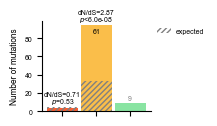

In [15]:
# for sampleee in repeated_samples:
for sampleee in ['all_samples']:
    sample_name_ = sampleee
    mut_filee    = f"{deepcsa_run_dir}/clean_somatic/{sample_name_}.somatic.mutations.tsv"
    omega_filee  = f"{deepcsa_run_dir}/omegagloballoc/output_mle.{sample_name_}.global_loc.tsv"
    print(sampleee)
    
    generate_all_side_figures(sample_name_,
                              mut_filee,
                              omega_filee,
                              ["PIK3CA"],
                              # gene_order_positive_selection,
                              plotts= plots_dir,
                              # ymaximum=40,
                              # between_text = 1.5,
                              # withinbartext_off = 1.8,
                              # text_off = 0.5
                              title = False,
                              legendd = True
                              )

